In [1]:
import argparse
import time
import msgpack
from enum import Enum, auto

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 12

from planning_utils import a_star, a_star_graph, heuristic, create_grid, Graph, prune_path, find_graph_start_goal
from sampling import Sampler
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local, local_to_global

In [2]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()


In [15]:
class MotionPlanning(Drone):

    def __init__(self, connection, graph):
        super().__init__(connection)

        self.target_position = np.array([0.0, 0.0, 0.0])
        self.waypoints = []
        self.in_mission = True
        self.check_state = {}
        self.graph = graph

        # initial state
        self.flight_state = States.MANUAL

        # register all your callbacks here
        self.register_callback(MsgID.LOCAL_POSITION, self.local_position_callback)
        self.register_callback(MsgID.LOCAL_VELOCITY, self.velocity_callback)
        self.register_callback(MsgID.STATE, self.state_callback)
        
    def local_position_callback(self):
        if self.flight_state == States.TAKEOFF:
            if -1.0 * self.local_position[2] > 0.95 * self.target_position[2]:
                self.waypoint_transition()
        elif self.flight_state == States.WAYPOINT:
            if np.linalg.norm(self.target_position[0:2] - self.local_position[0:2]) < 1.0:
                if len(self.waypoints) > 0:
                    self.waypoint_transition()
                else:
                    if np.linalg.norm(self.local_velocity[0:2]) < 1.0:
                        self.landing_transition()

    def velocity_callback(self):
        if self.flight_state == States.LANDING:
            if self.global_position[2] - self.global_home[2] < 0.1:
                if abs(self.local_position[2]) < 0.01:
                    self.disarming_transition()

    def state_callback(self):
        if self.in_mission:
            if self.flight_state == States.MANUAL:
                self.arming_transition()
            elif self.flight_state == States.ARMING:
                if self.armed:
                    self.plan_path()
            elif self.flight_state == States.PLANNING:
                self.takeoff_transition()
            elif self.flight_state == States.DISARMING:
                if ~self.armed & ~self.guided:
                    self.manual_transition()

    def arming_transition(self):
        self.flight_state = States.ARMING
        print("arming transition")
        self.arm()
        self.take_control()

    def takeoff_transition(self):
        self.flight_state = States.TAKEOFF
        print("takeoff transition")
        self.takeoff(self.target_position[2])

    def waypoint_transition(self):
        self.flight_state = States.WAYPOINT
        print("waypoint transition")
        self.target_position = self.waypoints.pop(0)
        print('target position', self.target_position)
        self.cmd_position(self.target_position[0], self.target_position[1], self.target_position[2], self.target_position[3])

    def landing_transition(self):
        self.flight_state = States.LANDING
        print("landing transition")
        self.land()

    def disarming_transition(self):
        self.flight_state = States.DISARMING
        print("disarm transition")
        self.disarm()
        self.release_control()

    def manual_transition(self):
        self.flight_state = States.MANUAL
        print("manual transition")
        self.stop()
        self.in_mission = False

    def send_waypoints(self):
        print("Sending waypoints to simulator ...")
        data = msgpack.dumps(self.waypoints)
        self.connection._master.write(data)

    def plan_path(self):
        self.flight_state = States.PLANNING
        print("Searching for a path ...")
        SAFETY_DISTANCE = 5

        # read lat0, lon0 from colliders into floating point values
        lat0, lon0, alt0 = 37.792480, -122.397450, 0.

        # set home position to (lon0, lat0, 0)
        self.set_home_position(longitude=lon0, latitude=lat0, altitude=alt0)

        # convert to current local position using global_to_local()
        start_ne = global_to_local(self.global_position, self.global_home)
        print('Start NED', start_ne)
        goal_ne = (start_ne[0]+250., start_ne[1]+20., 50.)
        
        print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                         self.local_position))        
        
        # find closest graph vertices to start and goal locations
        graph_start, graph_goal = find_graph_start_goal(self.graph, start_ne, goal_ne)

        # Run A* to find a path from start to goal
        print('Local Start and Goal: ', graph_start, graph_goal)
        path, _ = a_star_graph(self.graph, heuristic, tuple(graph_start), tuple(graph_goal))
#         path = [(0., 0., 5.),
#                 (5., 0., 50.)]
    
        # Convert path to waypoints
        waypoints = [[p[0], p[1], p[2], 0] for p in path]
        # Set self.waypoints
        self.waypoints = waypoints
        # TODO: send waypoints to sim
        self.send_waypoints()

    def start(self):
        self.start_log("Logs", "NavLog.txt")

        print("starting connection")
        self.connection.start()

        # Only required if they do threaded
        # while self.in_mission:
        #    pass

        self.stop_log()


In [4]:
# Read in obstacle map
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)

def create_prm_graph(data):
    # Define a grid for a particular altitude and safety margin around obstacles
    print('Creating a grid...')
    grid, _, _ = create_grid(data, 1, 5)
    # Build PRM graph
    print('Sampling collision free points...')
    sampler = Sampler(data)
    polygons = sampler._polygons
    # sampling 300 points and removing ones conflicting with obstacles.
    nodes = sampler.sample(300)
    print('Building a PRM graph...')
    graph = Graph(nodes, polygons)
    graph.create_graph(10)
    print('Done!')
    return graph

graph = create_prm_graph(data)

Creating a grid...
Sampling collision free points...
Building a PRM graph...


In [16]:
conn = MavlinkConnection('tcp:127.0.0.1:5760', timeout=60)

In [17]:
drone = MotionPlanning(conn, graph)

Logs/TLog.txt


In [ ]:
drone.start()

Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
Start NED [-0.06577318  0.12369246 -0.077     ]
global home [-122.3957515   37.7932818    0.       ], position [-1.22395750e+02  3.77932812e+01  7.70000000e-02], local position [-0.06184881  0.12224114 -0.07745279]
Sending waypoints to simulator ...
takeoff transition
waypoint transition
target position [0.0, 0.0, 5.0, 0]
waypoint transition

### PRM Path construction tests

In [6]:
# Read in obstacle map
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
grid, _, _ = create_grid(data, 1, 5)

sampler = Sampler(data)
polygons = sampler._polygons

# Sampling 300 points and removing ones conflicting with obstacles.
nodes = sampler.sample(300)
print(len(nodes))

195


In [1]:
graph = Graph(nodes, polygons)
graph.create_graph(10)

#### A* planning on a graph

In [16]:
start_ne = (150., 10., 5.) #list(g.nodes)[10]
goal_ne = (700., 20., 5.) #list(g.nodes)[12]       
    
    
graph_start, graph_goal = find_graph_start_goal(graph, start_ne, goal_ne)

print(start_ne, goal_ne)
print(graph_start, graph_goal)

(150.0, 10.0, 5.0) (700.0, 20.0, 5.0)
(147.6717659611689, -12.186303312870564, 3.871847032118081) (585.4931735455532, 38.900945275961305, 3.076325072140005)


In [17]:
path, cost = a_star_graph(graph, heuristic, tuple(graph_start), tuple(graph_goal))
print(path, cost)

Found a path.
[[147.67176596 -12.18630331   3.87184703]
 [145.37871262  51.32060618   7.54886172]
 [236.5998232   60.93815458  15.06839721]
 [255.19681798  42.23199556  17.99409713]
 [329.61121276 -44.70806185  14.85685837]
 [356.44991131 -57.5040825   18.75872792]
 [458.42302737 -73.48384571  14.68190335]
 [515.62225169   1.58460745  18.78933649]
 [585.49317355  38.90094528   3.07632507]] 2495.2149725354834


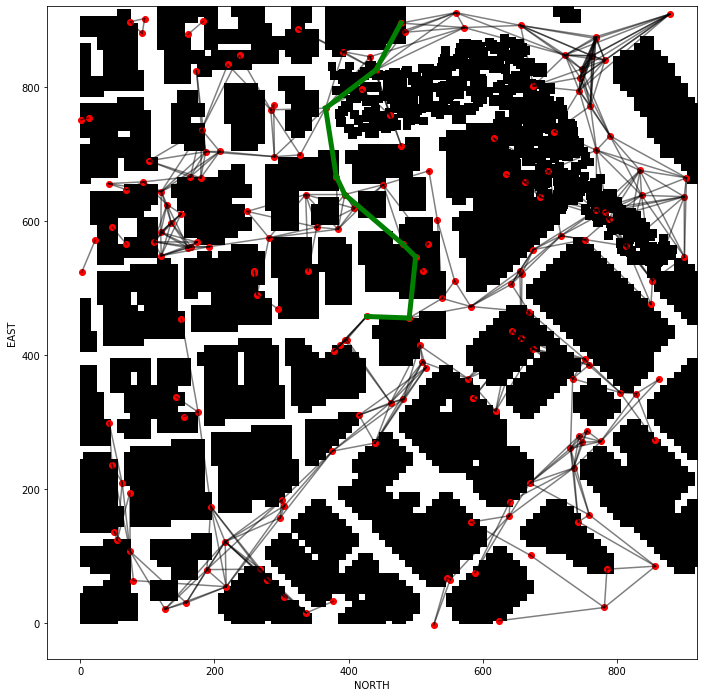

In [20]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# If you have a graph called "graph" these plots should work
# Draw edges
for (n1, n2) in graph.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)
    
# Draw connected nodes in red
for n1 in graph.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')

# Add code to visualize path here
# plt.plot(path[:, 1], path[:, 0], linewidth=5, label='path')
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'green', linewidth=5)
    
plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()